# 5pDEER DEMO
 The aim of this script is to set out the basic design/implementation for running incoherent pump pulses on the C Floor AWG.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autoDeer.hardware.keysight_awg as ksawg
import autoDeer.hardware.pulses as pulses
import autoDeer.hardware.xepr_experiments as exp
import autoDeer.hardware.awg_experiments as awg_exp
from autoDeer.ResPro import resonatorProfile
from autoDeer.FieldSweep import FieldSweep
from autoDeer.hardware import xepr_api as api
import autoDeer.Param_Optimization as po
import time


## Setup

### Connecting to the AWG
The Sequencing mode on both channels should be "STSC"

In [2]:
awg = ksawg.Interface()
awg.open_con('129.132.218.87')
awg._inst_init()
print(f"Checking Sequencing mode:{awg.getFunctionMode(3)}")
sampling_freq = 12e9
sampling_period = 1/sampling_freq
grad = 64


Socket Created
Identification String: b'Agilent Technologies,M8190A,DE52200268,5.0.14.0-2\n'
Checking Sequencing mode:('STSC\n', 'STSC\n')


## Connecting to Bruker

In [3]:
xepr=api() # This can only be run once per kernel
xepr.find_Xepr()
xepr.find_cur_exp()
xepr.find_hidden()

In [30]:
# This sets up the configuration file of spectrometer
if xepr.hidden['PlsPrgCalDbName'].value != 'Q_awgins2013':
    xepr.hidden['PlsPrgCalDbName'].value = 'Q_awgins2013'
    xepr.hidden['PlsPrgCalDbLoad']
    xepr.hidden['ApplyCfg']

In [35]:
xepr.set_field(11820)

11820.0

## Initial Tuning of MPFU Channel

In [37]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["pi/2 tp=p1 +<x>/-<x>","+<x> (pi/2)"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})


## Resonator Profile

Go to the central frequency of the dip.
Find the rough field maximum and tune +-\<x\> channels for 16ns pulses

In [27]:
xepr.cur_exp['CenterField'].value = 8000

In [38]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["Field Sweep +<x>/-<x> pg=200ns","Field sweep +<x>/-<x>"],
    {"PhaseCycle":False,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":25,"n":1,"d0":600})

time.sleep(10)



ZeroDivisionError: float division by zero

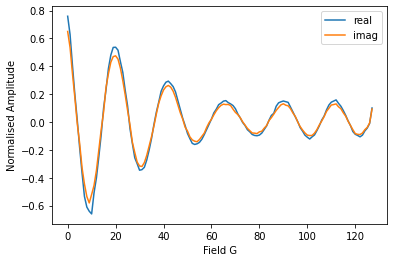

In [53]:
fs_data = xepr.acquire_scan()
fs = FieldSweep()
fs.import_from_dataclass(fs_data)
fs.find_max()

xepr.set_field(fs.max_field)
Bc = xepr.get_field()
fc = xepr.get_counterfreq()

fs.plot()
gyro_exp = fc/Bc
print(gyro_exp)

Confirm that two consecutive nutation experiments produce the same result. This confirms that everything is set up correctly.

In [40]:
awg_exp.sequence_nutation(awg,1,1,128,20)

In [41]:
awg.Abort()
awg.StartSigGen(3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


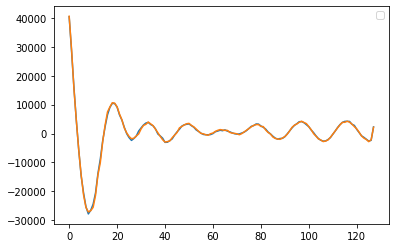

In [42]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["AWG seq inv (p2)","AWG +-<x> obs"],
    {"PhaseCycle":True},
    {"p0":16,"p1":16,"h":10,"n":1,"d0":580},False)

time.sleep(2)
xepr.run_exp()
time.sleep(2)
run1 = xepr.acquire_scan()

xepr.run_exp()
time.sleep(2)
run2 = xepr.acquire_scan()
plt.plot(run1.time,np.real(run1.data),
        run2.time,np.real(run2.data))
plt.legend()

Now run the resonator profile script

In [43]:
t,nutation_data = exp.get_nutations(xepr,
                                    nu=[33, 34],
                                    field=[fc,Bc],
                                    step=20e-3)

In [8]:
xepr.hidden['Frequency'].value

2915.0

Finding and fitting the resonator profile

/home/xuser/Desktop/huka/autoDeer/autoDeer/ResPro.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = self.q * (frq**2 -self.fc**2)/(frq*self.fc)
/home/xuser/Desktop/huka/autoDeer/autoDeer/ResPro.py:118: RuntimeWarning: invalid value encountered in multiply
  model = (1-z*1j )/ (1 + z**2) # Lorentzian = 1-zj/(1+z^2)
/home/xuser/Desktop/huka/autoDeer/autoDeer/ResPro.py:118: RuntimeWarning: invalid value encountered in true_divide
  model = (1-z*1j )/ (1 + z**2) # Lorentzian = 1-zj/(1+z^2)
/home/xuser/Desktop/huka/autoDeer/autoDeer/ResPro.py:155: RuntimeWarning: divide by zero encountered in log
  h_pha = np.imag(hilbert(-np.log(habs)))
/home/xuser/miniconda3/envs/autodeer/lib/python3.9/site-packages/scipy/signal/signaltools.py:2300: RuntimeWarning: invalid value encountered in multiply
  x = sp_fft.ifft(Xf * h, axis=axis)


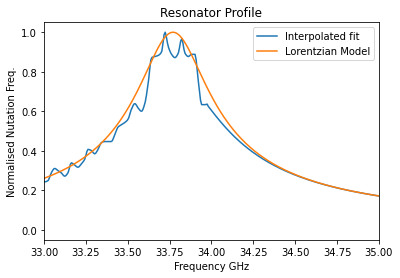

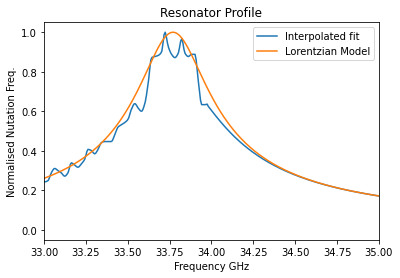

In [44]:
rp = resonatorProfile()
res_prof = rp.calc_res_prof(nutation_data,dt=t[1]-t[0])
rp.autofit([33,35])
rp.calculate_shape(res_prof,None)
rp.calc_IF_prof(2,rp.fc,type='fit')
rp.res_prof_plot([33,35])


Now go to the calculated fc, and do another field sweep. This is the new central frequency

In [58]:
print(f"fc = {rp.fc:.2f} GHz")
print(f"Bc = {rp.fc/0.0028024:.0f} G")
xepr.set_freq(rp.fc)
xepr.set_field(rp.fc/0.0028024)


fc = 33.77 GHz
Bc = 12050 G


12050.45

In [ ]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["Field Sweep +<x>/-<x> pg=200ns","Field sweep +<x>/-<x>"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2,"d0":600})

time.sleep(10)

Bc = 11988
Gyro = 2.817


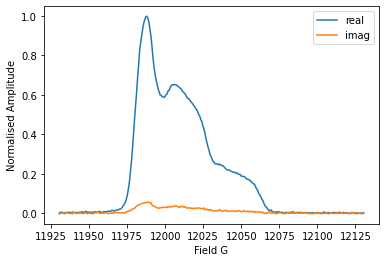

In [65]:
fs_data = xepr.acquire_scan()
fs = FieldSweep()
fs.import_from_dataclass(fs_data)
fs.find_max()

xepr.set_field(fs.max_field)
Bc = xepr.get_field()
fc = xepr.get_counterfreq()

fs.plot()
gyro_exp = fc/(Bc/1000)
print(f"Bc = {Bc:.0f}")
print(f"Gyro = {gyro_exp:.3f}")

## Relaxation Experiments

These need to be done on the normal channels. So tune the main channel

In [ ]:
awg.Abort() # Make sure AWG has stopped
po.main_run(xepr,[16,32],d0,)


## DEER Experiments

Now we need to setup the 5pDEER experiment. For this to work we need to setup the pulses for the observer channel, there is no need to setup the AWG pulses

In [74]:
# Set the frequency and field tempoarily to the observer position.
fobs = fc - 0.07
xepr.set_freq(fobs)
xepr.set_field(fobs/gyro_exp * 10000)
# +<x>
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["pi/2 tp=p1 +<x>/-<x>","+<x> (pi/2)"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})


In [75]:
# -<x>
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["pi/2 tp=p1 +<x>/-<x>","-<x> (pi/2)"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})


In [91]:
# -<y>
# This is tunned to be in phase with +<x> i.e. Real echo up
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["pi tp=p1 -<y>","-<y> echo up!"],
    {"PhaseCycle":False},
    {"p0":16,"p1":16,"h":20,"n":2})


In [81]:
d0 = 610

In [84]:
tau2 = 500
deadtime = 80
scans = 200
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["5p DEER","DEER run AWG -+<x>"],
    {"PhaseCycle":True,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":20,"n":scans,"d2":tau2,"d11":200,"d3":deadtime,"d0":d0,"dim8":10})


In [101]:
# Set the Bm
fpump = fc + 0.05
xepr.set_freq(fobs)
xepr.set_field(fpump/gyro_exp * 10000)

12005.75

In [102]:
# Building the HS pulses and sending them to the AWG
awg_exp.deer_pulse_5p(awg,100,[2.07,2.32])

[array([ 0.        +0.01347528j,  0.01200864+0.00635825j,
         0.01133245-0.00770152j, ..., -0.00762846-0.01363418j,
        -0.01470207+0.00228322j, -0.00284125+0.01387525j]),
 array([ 0.        +0.01347528j,  0.01327334+0.00493631j,
         0.00972068-0.01126151j, ..., -0.01084808-0.0085564j ,
        -0.01253311+0.00553703j, -0.00096312+0.01355386j])]

In [103]:
tau2 = 1500
deadtime = 80
scans = 200
step = 16
dim = np.floor((tau2 * 2 - deadtime)/step)
awg.StartSigGen(3)
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["5p DEER","DEER run AWG -+<x>"],
    {"PhaseCycle":True,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":20,"n":scans,"d2":tau2,"d11":200,"d3":deadtime,"d0":d0,"dim8":dim},
               run=False)


In [98]:
exp.run_general(xepr,
    ["/PulseSpel/HUKA_DEER_AWG"],
    ["5p DEER","DEER run AWG -+<x>"],
    {"PhaseCycle":True,"ReplaceMode":False},
    {"p0":16,"p1":16,"h":50,"d2":tau2,"d11":200,"d3":deadtime,"d0":d0,"dim8":dim},
               run=False)


In [99]:
dim

182.0